In [1]:
!pip install kagglehub
!pip install transformers
!pip install tqdm
!pip install nltk
!pip install pillow
!pip install torch==1.13.0+cu117 torchvision==0.14.0+cu117 torchaudio==0.13.0 -f https://download.pytorch.org/whl/torch_stable.html

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikhil7280/coco-image-caption")

print("Path to dataset files:", path)

Resuming download from 2458910720 bytes (12288757124 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/nikhil7280/coco-image-caption?dataset_version_number=1 (2458910720/14747667844) bytes left.


100%|██████████████████████████████████████████████████████████████████████████████| 13.7G/13.7G [11:22<00:00, 18.0MB/s]

Extracting model files...


Path to dataset files: /dgxa_home/se21uari120/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1


In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from transformers import BertTokenizer
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from nltk.translate.bleu_score import corpus_bleu  # For evaluation

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the tokenizer and compute vocabulary size based on the dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
vocab_size = len(tokenizer)
print(f"Vocabulary Size: {vocab_size}")

# Define the COCO dataset class
class CocoDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None, max_samples=None):
        self.image_dir = image_dir
        self.transform = transform

        # Load COCO annotations
        with open(captions_file, 'r') as f:
            data = json.load(f)

        self.image_filenames = []
        self.captions = []
        for annotation in data['annotations']:
            image_id = annotation['image_id']
            caption = annotation['caption']
            image_filename = f'COCO_train2014_{image_id:012d}.jpg'
            image_path = os.path.join(image_dir, image_filename)
            if os.path.exists(image_path):  # Ensure file exists
                self.image_filenames.append(image_path)
                self.captions.append(caption)

        # Limit to max_samples if provided
        if max_samples:
            self.image_filenames = self.image_filenames[:max_samples]
            self.captions = self.captions[:max_samples]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_filenames[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Tokenize caption
        caption = self.captions[idx]
        tokenized_caption = tokenizer(caption, padding="max_length", truncation=True, max_length=50, return_tensors="pt")
        input_ids = tokenized_caption["input_ids"].squeeze(0)
        attention_mask = tokenized_caption["attention_mask"].squeeze(0)

        return image, input_ids, attention_mask

# Define the captioning model
class CaptioningModel(torch.nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1):
        super(CaptioningModel, self).__init__()
        # Load ResNet and remove the last fully connected layer
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = torch.nn.Sequential(*list(self.resnet.children())[:-2])  # Remove FC and pooling layers
        self.resnet_fc = torch.nn.Linear(2048, embed_size)

        # Embedding and LSTM layers
        self.embedding = torch.nn.Embedding(vocab_size, embed_size)
        self.lstm = torch.nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc_out = torch.nn.Linear(hidden_size, vocab_size)

    def forward(self, images, captions):
        # Extract features from images
        features = self.resnet(images)
        features = features.mean([2, 3])  # Global Average Pooling
        features = self.resnet_fc(features)

        # Embed captions
        embedded = self.embedding(captions)
        features = features.unsqueeze(1)  # Add sequence dimension
        inputs = torch.cat((features, embedded), dim=1)

        # LSTM outputs
        outputs, _ = self.lstm(inputs)
        outputs = self.fc_out(outputs)
        return outputs

# Set up transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define dataset paths
image_dir = "/dgxa_home/se21uari120/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/train2014/train2014"
captions_file = "/dgxa_home/se21uari120/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/annotations_trainval2014/annotations/captions_train2014.json"

# Load the first 10000 samples
max_samples = None
dataset = CocoDataset(image_dir, captions_file, transform=transform, max_samples=max_samples)

# Split the dataset into train, val, and test (70%, 15%, 15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Ensure reproducibility
)

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, optimizer, and scheduler
model = CaptioningModel(vocab_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

# Training loop
num_epochs = 7
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as batch_bar:
        for images, input_ids, attention_mask in batch_bar:
            # Move images and input_ids to the correct device
            images, input_ids = images.to(device), input_ids.to(device)

            optimizer.zero_grad()
            outputs = model(images, input_ids)

            seq_len = min(outputs.size(1), input_ids.size(1) - 1)
            outputs_trimmed = outputs[:, :seq_len, :]
            target_ids = input_ids[:, 1:seq_len + 1]

            outputs_flat = outputs_trimmed.reshape(-1, vocab_size)
            target_flat = target_ids.reshape(-1)

            loss = criterion(outputs_flat, target_flat)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            batch_bar.set_postfix(loss=loss.item())

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, input_ids, _ in val_loader:
            # Move images and input_ids to the correct device
            images, input_ids = images.to(device), input_ids.to(device)
            outputs = model(images, input_ids)

            seq_len = min(outputs.size(1), input_ids.size(1) - 1)
            outputs_trimmed = outputs[:, :seq_len, :]
            target_ids = input_ids[:, 1:seq_len + 1]

            outputs_flat = outputs_trimmed.reshape(-1, vocab_size)
            target_flat = target_ids.reshape(-1)

            loss = criterion(outputs_flat, target_flat)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss}")

# Save the best model based on validation loss
torch.save(model.state_dict(), "best_captioning_model.pth")

# BLEU Score Evaluation
def evaluate_bleu_score(model, data_loader, tokenizer, max_length=50):
    references = []
    predictions = []

    model.eval()
    with torch.no_grad():
        for images, input_ids, attention_mask in data_loader:
            images = images.to(device)
            input_ids = input_ids.to(device)
            outputs = model(images, input_ids)

            seq_len = min(outputs.size(1), input_ids.size(1) - 1)
            predicted_ids = outputs.argmax(dim=-1)

            for i in range(len(input_ids)):
                # Get ground truth
                ref_caption = tokenizer.decode(input_ids[i], skip_special_tokens=True).split()
                references.append([ref_caption])

                # Get predicted caption
                pred_caption = tokenizer.decode(predicted_ids[i], skip_special_tokens=True).split()
                predictions.append(pred_caption)

    return corpus_bleu(references, predictions)

# Evaluate BLEU score on the validation set
bleu_score = evaluate_bleu_score(model, val_loader, tokenizer)
print(f"BLEU score on the validation set: {bleu_score}")


Using device: cuda
Vocabulary Size: 30522


/dgxa_home/se21uari120/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/dgxa_home/se21uari120/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/7: 100%|██████████████████████████████████████████████████████| 2265/2265 [37:26<00:00,  1.01batch/s, loss=3.71]


Epoch 1/7, Training Loss: 4.080292013517805, Validation Loss: 3.739271586814535


Epoch 2/7: 100%|██████████████████████████████████████████████████████| 2265/2265 [37:15<00:00,  1.01batch/s, loss=3.47]


Epoch 2/7, Training Loss: 3.5970734410991207, Validation Loss: 3.593883366251188


Epoch 3/7: 100%|██████████████████████████████████████████████████████| 2265/2265 [37:37<00:00,  1.00batch/s, loss=3.31]


Epoch 3/7, Training Loss: 3.413145656880427, Validation Loss: 3.5119393166200616


Epoch 4/7: 100%|██████████████████████████████████████████████████████| 2265/2265 [37:32<00:00,  1.01batch/s, loss=3.32]


Epoch 4/7, Training Loss: 3.2827905952798875, Validation Loss: 3.4855071090376426


Epoch 5/7: 100%|██████████████████████████████████████████████████████| 2265/2265 [39:12<00:00,  1.04s/batch, loss=3.14]


Epoch 5/7, Training Loss: 3.184147072469951, Validation Loss: 3.4752403296560908


Epoch 6/7: 100%|██████████████████████████████████████████████████████| 2265/2265 [37:12<00:00,  1.01batch/s, loss=3.02]


Epoch 6/7, Training Loss: 3.104149007691979, Validation Loss: 3.484999673356735


Epoch 7/7: 100%|██████████████████████████████████████████████████████| 2265/2265 [37:12<00:00,  1.01batch/s, loss=3.08]


Epoch 7/7, Training Loss: 3.033477672993742, Validation Loss: 3.4826116012447654
BLEU score on the validation set: 0.011540575168604305


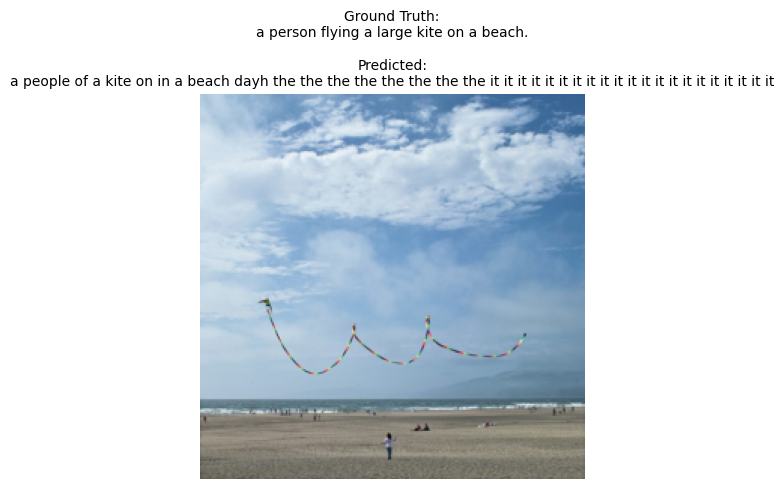

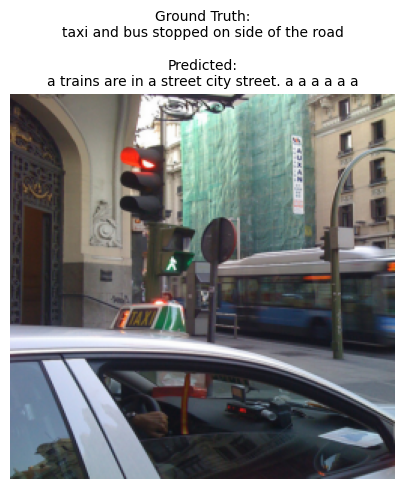

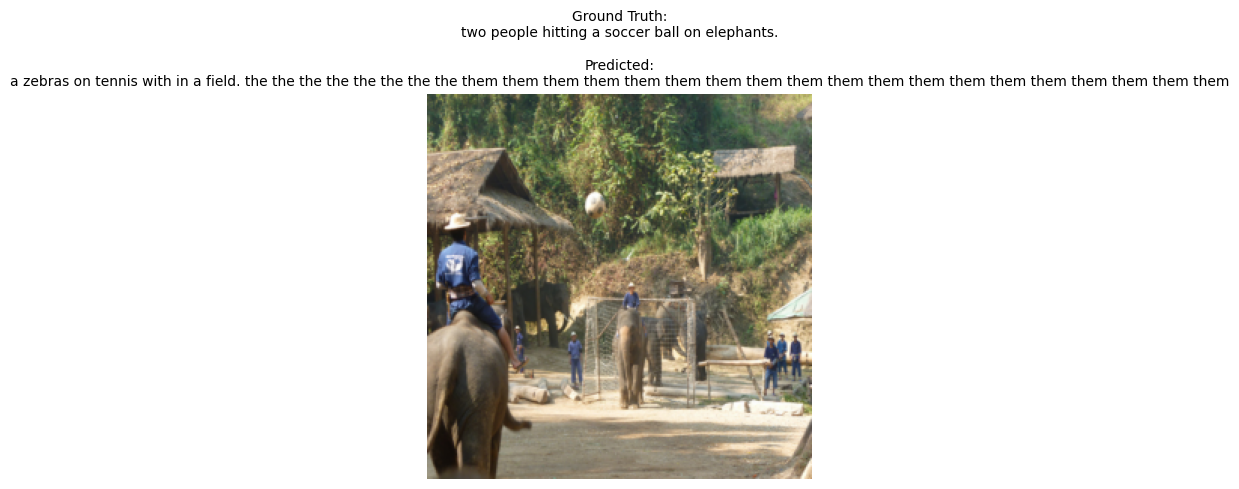

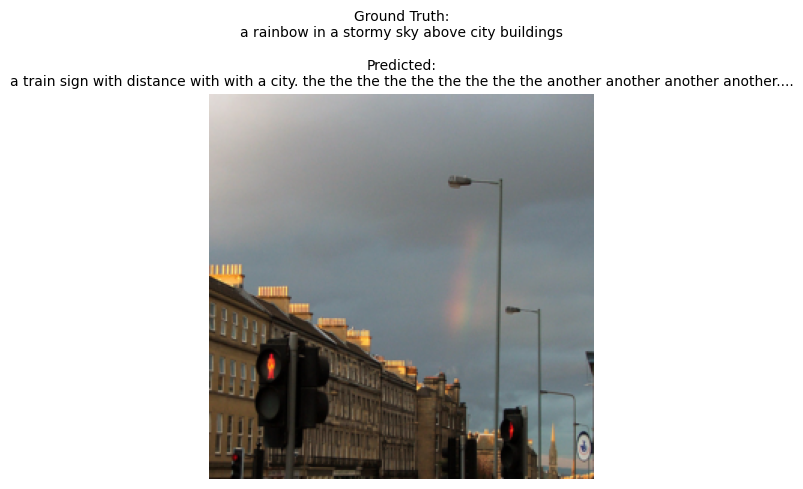

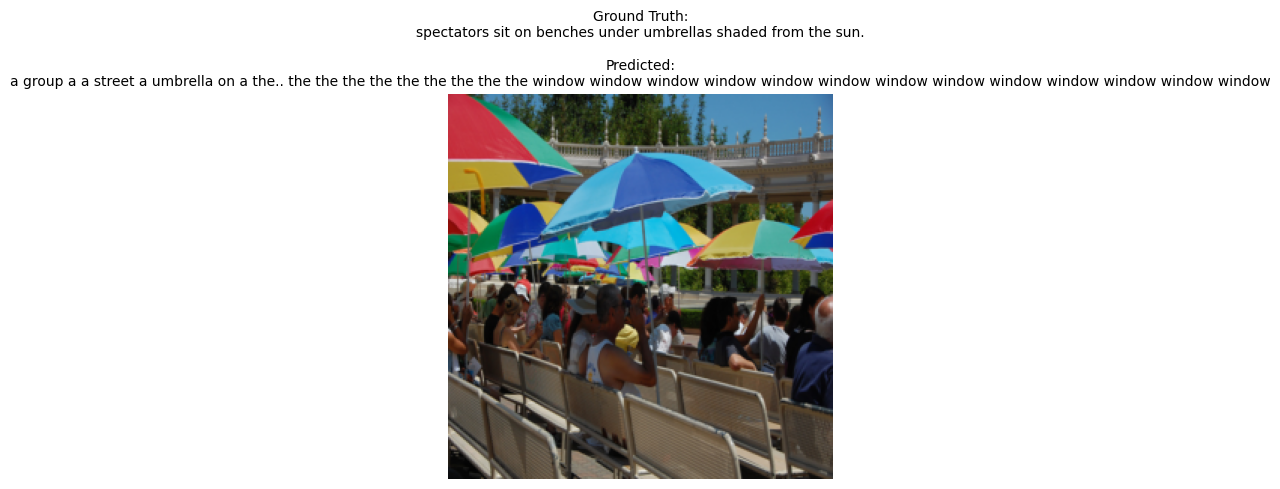

In [3]:
import matplotlib.pyplot as plt

def display_examples(data_loader, model, tokenizer, num_examples=5):
    model.eval()
    examples_shown = 0
    
    with torch.no_grad():
        for images, input_ids, attention_mask in data_loader:
            images = images.to(device)
            input_ids = input_ids.to(device)

            # Get predictions
            outputs = model(images, input_ids)
            predicted_ids = outputs.argmax(dim=-1)

            for i in range(len(images)):
                if examples_shown >= num_examples:
                    return
                
                # Decode ground truth caption
                ground_truth = tokenizer.decode(input_ids[i], skip_special_tokens=True)
                
                # Decode predicted caption
                predicted_caption = tokenizer.decode(predicted_ids[i], skip_special_tokens=True)

                # Display image and captions
                image = images[i].cpu().permute(1, 2, 0)  # Convert to HWC format
                image = (image * torch.tensor([0.229, 0.224, 0.225]) + 
                         torch.tensor([0.485, 0.456, 0.406])).clip(0, 1)  # De-normalize
                
                plt.figure(figsize=(5, 5))
                plt.imshow(image)
                plt.axis('off')
                plt.title(f"Ground Truth:\n{ground_truth}\n\nPredicted:\n{predicted_caption}", fontsize=10)
                plt.show()

                examples_shown += 1

# Call the function to display examples from the validation set
display_examples(val_loader, model, tokenizer, num_examples=5)


In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from transformers import BertTokenizer
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from nltk.translate.bleu_score import corpus_bleu  # For evaluation

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the tokenizer and compute vocabulary size based on the dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
vocab_size = len(tokenizer)
print(f"Vocabulary Size: {vocab_size}")

# Define the COCO dataset class
class CocoDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None, max_samples=None):
        self.image_dir = image_dir
        self.transform = transform

        # Load COCO annotations
        with open(captions_file, 'r') as f:
            data = json.load(f)

        self.image_filenames = []
        self.captions = []
        for annotation in data['annotations']:
            image_id = annotation['image_id']
            caption = annotation['caption']
            image_filename = f'COCO_train2014_{image_id:012d}.jpg'
            image_path = os.path.join(image_dir, image_filename)
            if os.path.exists(image_path):  # Ensure file exists
                self.image_filenames.append(image_path)
                self.captions.append(caption)

        # Limit to max_samples if provided
        if max_samples:
            self.image_filenames = self.image_filenames[:max_samples]
            self.captions = self.captions[:max_samples]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_filenames[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Tokenize caption
        caption = self.captions[idx]
        tokenized_caption = tokenizer(caption, padding="max_length", truncation=True, max_length=50, return_tensors="pt")
        input_ids = tokenized_caption["input_ids"].squeeze(0)
        attention_mask = tokenized_caption["attention_mask"].squeeze(0)

        return image, input_ids, attention_mask

# Define the captioning model
class CaptioningModel(torch.nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1):
        super(CaptioningModel, self).__init__()
        # Load ResNet and remove the last fully connected layer
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = torch.nn.Sequential(*list(self.resnet.children())[:-2])  # Remove FC and pooling layers
        self.resnet_fc = torch.nn.Linear(2048, embed_size)

        # Embedding and LSTM layers
        self.embedding = torch.nn.Embedding(vocab_size, embed_size)
        self.lstm = torch.nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc_out = torch.nn.Linear(hidden_size, vocab_size)

    def forward(self, images, captions):
        # Extract features from images
        features = self.resnet(images)
        features = features.mean([2, 3])  # Global Average Pooling
        features = self.resnet_fc(features)

        # Embed captions
        embedded = self.embedding(captions)
        features = features.unsqueeze(1)  # Add sequence dimension
        inputs = torch.cat((features, embedded), dim=1)

        # LSTM outputs
        outputs, _ = self.lstm(inputs)
        outputs = self.fc_out(outputs)
        return outputs

# Set up transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define dataset paths
image_dir = "/dgxa_home/se21uari120/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/train2014/train2014"
captions_file = "/dgxa_home/se21uari120/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/annotations_trainval2014/annotations/captions_train2014.json"

# Load the first 10000 samples
max_samples = None
dataset = CocoDataset(image_dir, captions_file, transform=transform, max_samples=max_samples)

# Split the dataset into train, val, and test (70%, 15%, 15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Ensure reproducibility
)

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, optimizer, and scheduler
model = CaptioningModel(vocab_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

# Training loop
num_epochs = 5
best_val_loss = float('inf')  # Initialize best validation loss
model_save_path = "best_captioning_model.pth"

# Training loop with progress bars
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch") as train_bar:
        for images, input_ids, attention_mask in train_bar:
            # Move data to the correct device
            images, input_ids = images.to(device), input_ids.to(device)

            optimizer.zero_grad()
            outputs = model(images, input_ids)

            # Adjust sequence lengths for training
            seq_len = min(outputs.size(1), input_ids.size(1) - 1)
            outputs_trimmed = outputs[:, :seq_len, :]
            target_ids = input_ids[:, 1:seq_len + 1]

            # Flatten outputs and targets for CrossEntropyLoss
            outputs_flat = outputs_trimmed.reshape(-1, vocab_size)
            target_flat = target_ids.reshape(-1)

            # Compute loss and backpropagate
            loss = criterion(outputs_flat, target_flat)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Update progress
            running_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

    # Validation loop with progress bar
    model.eval()
    val_loss = 0.0
    with tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch") as val_bar:
        with torch.no_grad():
            for images, input_ids, attention_mask in val_bar:
                # Move data to the correct device
                images, input_ids = images.to(device), input_ids.to(device)

                # Forward pass
                outputs = model(images, input_ids)

                # Adjust sequence lengths for validation
                seq_len = min(outputs.size(1), input_ids.size(1) - 1)
                outputs_trimmed = outputs[:, :seq_len, :]
                target_ids = input_ids[:, 1:seq_len + 1]

                # Flatten outputs and targets for CrossEntropyLoss
                outputs_flat = outputs_trimmed.reshape(-1, vocab_size)
                target_flat = target_ids.reshape(-1)

                # Compute validation loss
                loss = criterion(outputs_flat, target_flat)
                val_loss += loss.item()
                val_bar.set_postfix(loss=loss.item())

    # Compute average validation loss
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss}")

    # Save the model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"Best model saved with validation loss: {best_val_loss}")

    # Step the scheduler
    scheduler.step()

# BLEU Score Evaluation with Progress Bar
def evaluate_bleu_score(model, data_loader, tokenizer, max_length=50):
    references = []
    predictions = []

    model.eval()
    with tqdm(data_loader, desc="Evaluating BLEU Score", unit="batch") as bleu_bar:
        with torch.no_grad():
            for images, input_ids, attention_mask in bleu_bar:
                images = images.to(device)
                input_ids = input_ids.to(device)
                outputs = model(images, input_ids)

                seq_len = min(outputs.size(1), input_ids.size(1) - 1)
                predicted_ids = outputs.argmax(dim=-1)

                for i in range(len(input_ids)):
                    # Get ground truth
                    ref_caption = tokenizer.decode(input_ids[i], skip_special_tokens=True).split()
                    references.append([ref_caption])

                    # Get predicted caption
                    pred_caption = tokenizer.decode(predicted_ids[i], skip_special_tokens=True).split()
                    predictions.append(pred_caption)

    return corpus_bleu(references, predictions)

# Evaluate BLEU score on the validation set
bleu_score = evaluate_bleu_score(model, val_loader, tokenizer)
print(f"BLEU score on the validation set: {bleu_score}")


Using device: cuda
Vocabulary Size: 30522


/dgxa_home/se21uari120/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/dgxa_home/se21uari120/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5 - Validation: 100%|███████████████████████████████████████████| 486/486 [06:42<00:00,  1.21batch/s, loss=3.45]


Epoch 1/5, Training Loss: 4.115358985601935, Validation Loss: 3.7830765428857056
Best model saved with validation loss: 3.7830765428857056


Epoch 2/5 - Validation: 100%|████████████████████████████████████████████| 486/486 [06:44<00:00,  1.20batch/s, loss=3.3]


Epoch 2/5, Training Loss: 3.639082128533201, Validation Loss: 3.6345825730037298
Best model saved with validation loss: 3.6345825730037298


Epoch 3/5 - Validation: 100%|███████████████████████████████████████████| 486/486 [06:49<00:00,  1.19batch/s, loss=3.23]


Epoch 3/5, Training Loss: 3.4662737870584786, Validation Loss: 3.5712695028556225
Best model saved with validation loss: 3.5712695028556225


Epoch 4/5 - Validation: 100%|███████████████████████████████████████████| 486/486 [06:37<00:00,  1.22batch/s, loss=3.15]


Epoch 4/5, Training Loss: 3.3277746198456284, Validation Loss: 3.538211809264289
Best model saved with validation loss: 3.538211809264289


Epoch 5/5 - Validation: 100%|███████████████████████████████████████████| 486/486 [06:41<00:00,  1.21batch/s, loss=3.15]


Epoch 5/5, Training Loss: 3.238574789901969, Validation Loss: 3.5264550368972274
Best model saved with validation loss: 3.5264550368972274


Evaluating BLEU Score: 100%|███████████████████████████████████████████████████████| 486/486 [07:30<00:00,  1.08batch/s]


BLEU score on the validation set: 0.04520919134502574


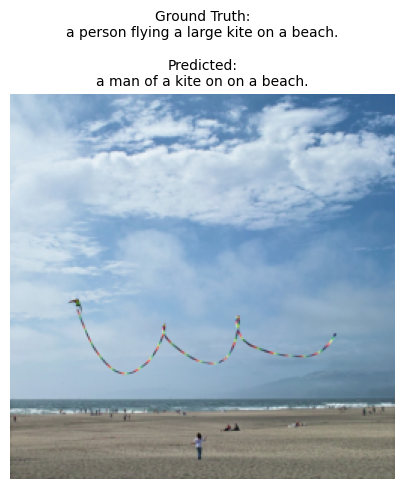

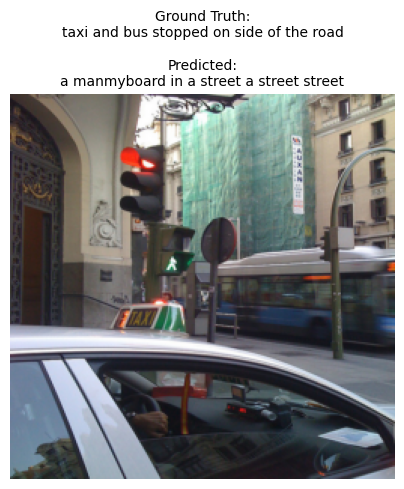

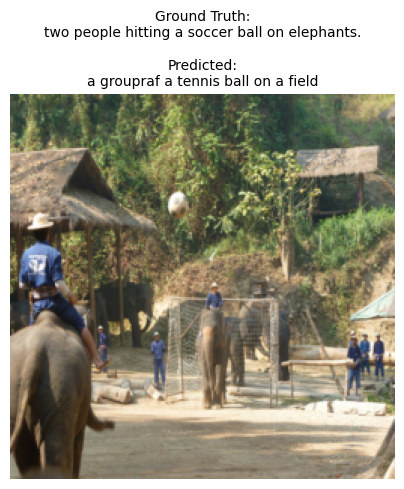

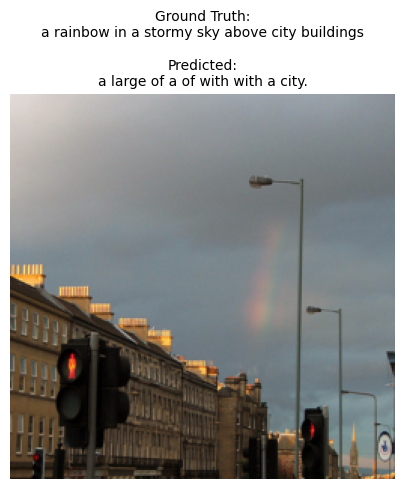

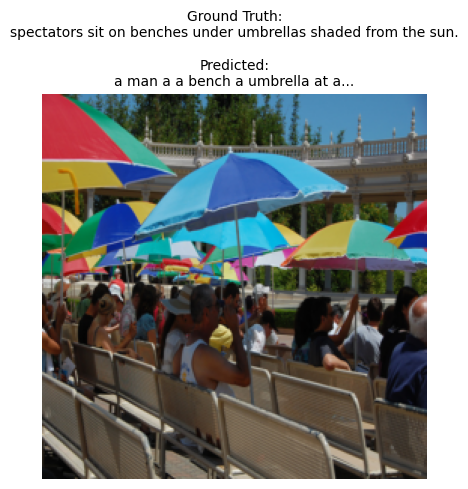

In [2]:
import matplotlib.pyplot as plt

def display_examples(data_loader, model, tokenizer, num_examples=5):
    model.eval()
    examples_shown = 0
    
    with torch.no_grad():
        for images, input_ids, attention_mask in data_loader:
            images = images.to(device)
            input_ids = input_ids.to(device)

            # Get predictions
            outputs = model(images, input_ids)
            predicted_ids = outputs.argmax(dim=-1)

            for i in range(len(images)):
                if examples_shown >= num_examples:
                    return
                
                # Decode ground truth caption
                ground_truth = tokenizer.decode(input_ids[i], skip_special_tokens=True)
                
                # Decode predicted caption
                predicted_caption = tokenizer.decode(predicted_ids[i], skip_special_tokens=True)

                # Display image and captions
                image = images[i].cpu().permute(1, 2, 0)  # Convert to HWC format
                image = (image * torch.tensor([0.229, 0.224, 0.225]) + 
                         torch.tensor([0.485, 0.456, 0.406])).clip(0, 1)  # De-normalize
                
                plt.figure(figsize=(5, 5))
                plt.imshow(image)
                plt.axis('off')
                plt.title(f"Ground Truth:\n{ground_truth}\n\nPredicted:\n{predicted_caption}", fontsize=10)
                plt.show()

                examples_shown += 1

# Call the function to display examples from the validation set
display_examples(val_loader, model, tokenizer, num_examples=5)
